In [11]:
cd pyDDM

/Users/sam/Documents/GitHub/pyDDM/pyDDM


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from bioviper import msa, pdb
from ddm import DDM, align_structures, helix_bin

from scipy import spatial
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA, SparsePCA, NMF

from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

#so that the pdfs produced are compatible with Adobe Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Arial"

helix_names = ['1a','1b','2','3','4','5a','5b','6a','6b','7','8','9','10a','10b']

def selector(df, dic):

    '''A little tool for selecting from pandas dataframes by passing a dictionary, e.g.
            selector(df, {"color":"red", "shape":["square", "circle"]})
        
        For advanced usage, you can pass a function and it will return where True, e.g.
            selector(df, ["name": lambda name: "Sam" in name])
            
        You can also use this to select things greater than or less than a value, e.g.
            selector(df, ["enrichment": lambda enr: enr > 1])'''
    
    X = df.copy()

    for key,val in dic.items():
        
        # If you pass a tuple, list or numpy array
        if isinstance(val, (tuple, list, np.ndarray)):
            where = np.any(np.array([X[key]==v for v in val]),axis=0)
            X = X.loc[where]
            
        # If you pass a function
        elif isinstance(val, type(lambda x: x+1)):
            X = X.loc[X[key].apply(val)]
            
        # Otherwise we assume it's a single value
        else:
            X = X.loc[X[key]==val]

    return X

In [46]:
def runPCA(hbDDMs, n_components, sparse=True, alpha=2, nonnegative=True, nonneg_method="rezero", positive_components=True,
          spca_method="lars", random_state=None):
    
    '''Run (sparse) principal component analysis on a set of hbDDMs.
    
        DDMs: a list or array of all DDMs
        n_components: how many components to use.
        Optional:
            sparse: whether to perform sparse pca (default TRUE, sparse PCA is better for this)
            nonnegative: whether to perform a correction to the PCA projections to make them all nonnegative
                and set the "zero" in PCA space to represent the identity DDM (zero matrix). Default TRUE.
            nonneg_method: if nonnegative==TRUE, two options for method:
                nonneg_method = rezero subtracts off the projection of the identity DDM from all other matrices
                nonneg_method = nnmf used nonnegative matrix factorization with a fixed H to perform nonnegative
                    linear regression on the components to generated nonnegative weights for each uncentered DDM
                    from the components. In practice, this should give nearly the same answer as rezero.
            '''
    
    hbDDMs = np.array(hbDDMs)
    N_samples = hbDDMs.shape[0]
    N_helices = hbDDMs.shape[1]
    
    all_hb_ddms_flattened = hbDDMs.reshape((N_samples, N_helices**2))
    
    if sparse:
        pca = SparsePCA(n_components = n_components, method=spca_method, alpha=alpha, random_state=random_state)
    else:
        pca = PCA(n_components=n_components, random_state=random_note)
        
    pca_proj = pca.fit_transform(all_hb_ddms_flattened)
    
    if positive_components:
        pos_arr = (np.mean(pca.components_, axis=1) > 0).astype('int') * 2 - 1
    else:
        pos_arr = np.ones((n_components))
        
    components = pca.components_ * pos_arr[:, None]
    
    if nonnegative:
        if nonneg_method == "rezero":
            projections = pca_proj * pos_arr - pca.transform([np.zeros((N_helices**2))])[0] * pos_arr
    else:
        projections = pca_proj * pos_arr
        
    return components, projections

def colormix(c1, c2):
    
    c3 = []
    for i in range(4):
        c3.append((c1[i] + c2[i])/2)
    return tuple(c3)

def colorshift(c1, k, shift_alpha=False):
    
    c3 = []
    for i in range(3):
        c3.append(c1[i] + k)
    
    if shift_alpha:
        c3.append(c1[3]+k)
    else:
        c3.append(c1[3])
    return tuple(c3)

In [14]:
hb_ddms = np.load("../data/hb_ddms.npy", allow_pickle=True).item()
all_transitions = pd.read_csv("../data/all_transitions.csv")

all_hb_ddms = np.array([hbddm for key,hbddm in hb_ddms.items()])
all_hb_ddms_flattened = np.array([hbddm.flatten() for key,hbddm in hb_ddms.items()])

transition = all_transitions["transition"]
unique_transitions = np.unique(transition)
trans_arr = np.array([np.where(unique_transitions==k)[0][0] for k in transition])

protein_names = all_transitions["name"]

spectral = sns.color_palette("Spectral", as_cmap=True)
pca_colors_bars = ["gray", spectral(0.9), spectral(0.7), spectral(0.5), spectral(0.3), spectral(0.1)]
pca_colors_heatmaps = ["gray", spectral(0.9), colorshift(spectral(0.7),-0.2), "#E4CD05", spectral(0.3), spectral(0.1)]

We've now arranged our DDMs in the correct format. (Not shown yet): from doing "regular" PCA, we decided that we want to use sparse PCA. Sparse PCA has a parameter, alpha, that controls the amount of sparsity. Let's try varying it to see what kind of value of alpha give a usefully interpretable level of sparsity:

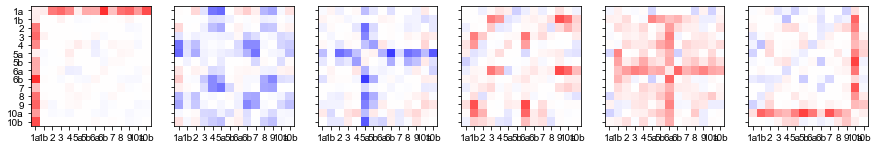

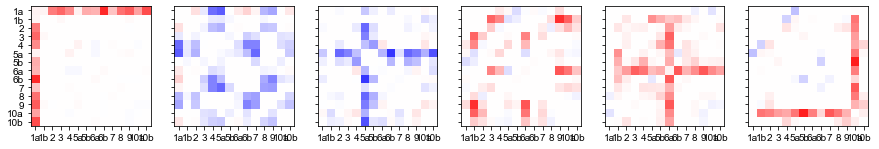

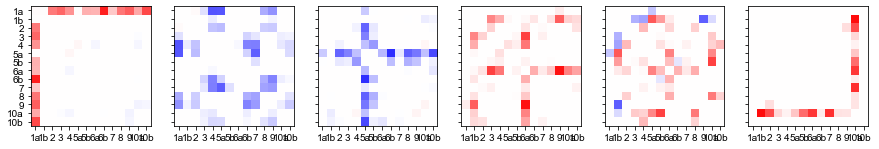

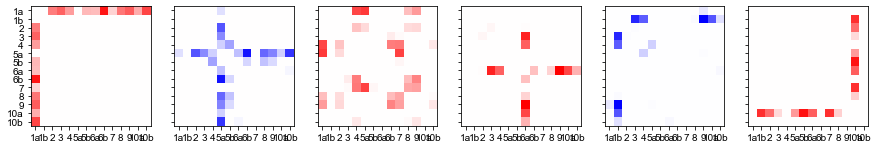

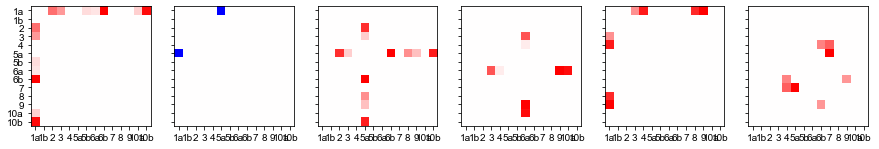

In [27]:
# How does varying the alpha parameter change things?

for alpha_param in [0.1, 0.5, 1, 2, 5]:

    spca = SparsePCA(n_components = 6, method='lars', alpha=alpha_param)

    spca_embedding = spca.fit_transform(all_hb_ddms_flattened)

    fig, axs = plt.subplots(1,6, figsize=(15,2.5), sharey=True)
    for component, axis in zip(spca.components_, axs):
        im = axis.imshow(component.reshape((14,14)), cmap="bwr", vmax=0.4, vmin=-0.4)
        axis.set_xticks(np.arange(len(helix_names)), helix_names, fontsize=10)
        axis.set_yticks(np.arange(len(helix_names)), helix_names, fontsize=10)
    #axs[-1].colorbar()

The low values are pretty similar to regular PCA. By the highest value (5), we're getting something extremely sparse, but it strikes me as maybe a bit *too* sparse. A value of 2 seems to produce a level of sparsity that strikes me as quite biochemically interpretable.

Let's look more systematically as the mean squared reconstruction error for different choices of our parameters (sparsity and number of components). Note that I'm using mean squared reconstruction error because the percent of explained variance isn't well-defined for sklearn's implementation of sprase PCA.

In [28]:
# Initialize an empty list
recon_loss = []

# We're 
for alpha_param in [0.1, 0.5, 1, 2, 5]:
    for nc in range(1,20):

        comp, proj = runPCA(all_hb_ddms, alpha=alpha_param, n_components=nc)

        for i in range(22):
            
            # reconstruct the ddm from the weighted sums of the components
            recon = np.sum([comp[k].reshape((14,14)) * proj[i][k] for k in range(nc)], axis=0)
            
            # calculate the mean squared error
            mse = np.sqrt(np.mean((recon - hb_ddms[i])**2))

            recon_loss.append([nc, alpha_param, mse])
            
df = pd.DataFrame(recon_loss, columns=("n_components", "alpha", "reconstruction error"))

In [30]:
df["log_alpha"] = np.log(df["alpha"])

<Axes: xlabel='n_components', ylabel='reconstruction error'>

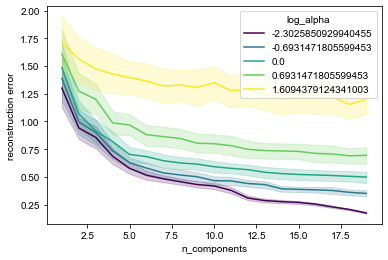

In [31]:
sns.lineplot(data=df, x="n_components", y="reconstruction error", hue="log_alpha", palette="viridis")

In [35]:
df.to_csv("../data/reconstruction_loss.csv")

Here's the plot for $\alpha=2$ that we show in Fig 3:

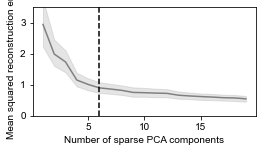

In [ ]:
reconstruction_error_alpha2 = selector(df, {"alpha":2})

plt.figure(figsize=(4,2))
sns.lineplot(data=reconstruction_error_alpha2, x="n_components", y="reconstruction error", color="grey")
plt.ylabel("Mean squared reconstruction error"); plt.xlabel("Number of sparse PCA components")
plt.ylim(0, 3.5)
plt.axvline(6, c='k', linestyle='dashed')

Below we'll do some cross validation experiments. First, we'll do a simple train-test split where we just leave out 20% of the hb-DDMs, train on the 80% and reconstruct the left out 20%. This is not a great cross-validation because there is a lot of overlap between the hb-DDMs.

In [15]:
from sklearn.model_selection import train_test_split

# # Initialize an empty list
recon_loss = []

for rep in range(10):
    hb_ddms_train, hb_ddms_test = train_test_split(all_hb_ddms, test_size=0.2)

    # # We're fixing these parameters based on the analysis used in the paper
    alpha = 2
    nc = 6

    def train_sparse_pca(train_hbDDMs, nc, alpha):
        N_samples = train_hbDDMs.shape[0]
        N_helices = train_hbDDMs.shape[1]

        all_hb_ddms_flattened = train_hbDDMs.reshape((N_samples, N_helices**2))

        pca = SparsePCA(n_components = nc, method='lars', alpha=alpha).fit(all_hb_ddms_flattened)
        
        return pca


    def get_sparse_pca_weights(test_hbDDMs, pca_model):
        N_samples = test_hbDDMs.shape[0]
        N_helices = test_hbDDMs.shape[1]

        all_hb_ddms_flattened = test_hbDDMs.reshape((N_samples, N_helices**2))
        
        pca_proj = pca_model.transform(all_hb_ddms_flattened)
        
        pos_arr = (np.mean(pca_model.components_, axis=1) > 0).astype('int') * 2 - 1
            
        components = pca_model.components_ * pos_arr[:, None]

        projections = pca_proj * pos_arr - pca_model.transform([np.zeros((N_helices**2))])[0] * pos_arr
        
        return components, projections

    pca = train_sparse_pca(hb_ddms_train, nc, alpha)

    comp, proj = get_sparse_pca_weights(hb_ddms_test, pca)

    # # reconstruct the ddm from the weighted sums of the components
    for i in range(len(proj)):
        recon = np.sum([comp[k].reshape((14,14)) * proj[i][k] for k in range(6)], axis=0)

        # # calculate the mean squared error
        mse = np.sqrt(np.mean((recon - hb_ddms_test[i])**2))

        recon_loss.append([rep, mse])

As a better cross-validation, let's split by protein. Because we only have 9 total proteins, we'll just do leave-one-out cross validation where we systematically leave out each protein (and its 1-6 hb-DDMs) from the training dataset, infer components based on the other 8 proteins, then learn the weights for the left-out hb-DDMs and reconstruct them.

In [37]:
unique_proteins = np.unique(all_transitions['name'])

recon_loss_protein_split = []

for unique_protein in unique_proteins:
    
    train_indices = np.where(all_transitions['name']!=unique_protein)[0]
    test_indices = np.where(all_transitions['name']==unique_protein)[0]
    
    hb_ddms_train = np.array([hb_ddms[i] for i in train_indices])
    hb_ddms_test = np.array([hb_ddms[i] for i in test_indices])
    
    pca = train_sparse_pca(hb_ddms_train, nc, alpha)

    comp, proj = get_sparse_pca_weights(hb_ddms_test, pca)

    # # reconstruct the ddm from the weighted sums of the components
    for i in range(len(proj)):
        recon = np.sum([comp[k].reshape((14,14)) * proj[i][k] for k in range(6)], axis=0)

        # # calculate the mean squared error
        mse = np.sqrt(np.mean((recon - hb_ddms_test[i])**2))

        recon_loss_protein_split.append([unique_protein, mse])

1.0561981302244303


<Axes: xlabel='protein', ylabel='reconstruction_error'>

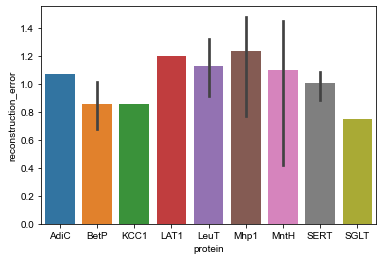

In [42]:
losses = pd.DataFrame(recon_loss_protein_split, columns=("protein", "reconstruction_error"))

print(np.mean(losses.reconstruction_error))

sns.barplot(data=losses, x="protein", y="reconstruction_error")

Just for fun: what if we split by transition instead?

0.9633004492250747


<Axes: xlabel='transition', ylabel='reconstruction_error'>

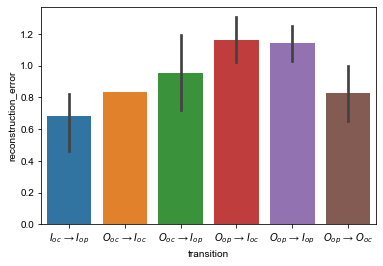

In [48]:
unique_transitions = np.unique(all_transitions['transition'])

recon_loss_trans_split = []

for unique_transition in unique_transitions:
    
    train_indices = np.where(all_transitions['transition']!=unique_transition)[0]
    test_indices = np.where(all_transitions['transition']==unique_transition)[0]
    
    hb_ddms_train = np.array([hb_ddms[i] for i in train_indices])
    hb_ddms_test = np.array([hb_ddms[i] for i in test_indices])
    
    pca = train_sparse_pca(hb_ddms_train, nc, alpha)

    comp, proj = get_sparse_pca_weights(hb_ddms_test, pca)

    # reconstruct the ddm from the weighted sums of the components
    for i in range(len(proj)):
        recon = np.sum([comp[k].reshape((14,14)) * proj[i][k] for k in range(6)], axis=0)

        # calculate the mean squared error
        mse = np.sqrt(np.mean((recon - hb_ddms_test[i])**2))

        recon_loss_trans_split.append([unique_transition, mse])
        
losses = pd.DataFrame(recon_loss_trans_split, columns=("transition", "reconstruction_error"))

print(np.mean(losses.reconstruction_error))

sns.barplot(data=losses, x="transition", y="reconstruction_error")

This is better than the protein split! At first I thought it would be a harder task, but actually it makes sense that it is easier because each transition has a similar transition, e.g. even if we're missing Ooc -> Iop, we still have Ioc --> Iop and Ooc --> Ioc.

For the next portion, I will make plots using the PCA embeddings for *all* DDMs, without any train-test split, to analyze further:

In [48]:
nc = 6

comp, proj = runPCA(all_hb_ddms, n_components=nc, random_state=83971])

X = []

for c1, trans, pn in zip(proj, transition, protein_names):
    for nj,j1 in zip(range(6), c1):
        X.append([nj, j1, trans, pn])
        
X = pd.DataFrame(X, columns=["PC", "value", "transition", "protein_name"])

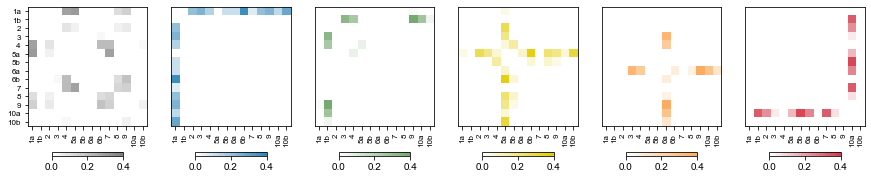

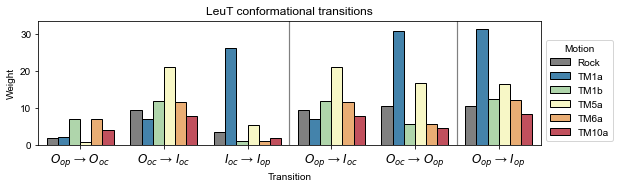

In [67]:
spectral = sns.color_palette("Spectral", as_cmap=True)

colors1 = ["gray", spectral(0.9), spectral(0.7), colorshift(spectral(0.5),0), spectral(0.3), spectral(0.1)]

# For better distinguishing colors on heatmaps, I darkened the green slightly and 
colors2 = ["gray", spectral(0.9), colorshift(spectral(0.7),-0.2), "#E4CD05", spectral(0.3), spectral(0.1)]
#colors2 = ["gray", spectral(0.9), colorshift(spectral(0.7),-0.2), "xkcd:sun yellow", spectral(0.3), spectral(0.1)]
#colors2 = ["gray", spectral(0.9), colorshift(spectral(0.7),-0.2), colorshift(spectral(0.45), -0.2), spectral(0.3), spectral(0.1)]

hue_order = np.array([2, 0, 4, 1, 3, 5])

fig, axs = plt.subplots(1, 6, figsize=(6*2.5, 4))

for n, component, axis in zip(range(6), comp[hue_order], axs):
    im = axis.imshow(component.reshape((14,14)), cmap=LinearSegmentedColormap.from_list(
        "Custom", ("white", pca_colors_heatmaps[n]), N=20), vmin=0, vmax=0.4)
    
    axis.set_xticks(np.arange(len(helix_names)), helix_names, fontsize=8, rotation=90)
    
    if n==0:
        axis.set_yticks(np.arange(len(helix_names)), helix_names, fontsize=8)
    else:
        axis.set_yticks([])

    fig.colorbar(im, ax=axis, orientation='horizontal', pad=0.12, shrink=0.6)
    
# plt.savefig("PCA_components_recolored_scaled.pdf", bbox_inches="tight")

LeuT_X = selector(X, {"protein_name":"LeuT"})
fig, ax = plt.subplots(figsize=(len(LeuT_X)*0.25,2.2857))

g = sns.barplot(data=LeuT_X, x="transition", y="value", hue="PC", edgecolor="k", lw=1,
           hue_order = [2, 0, 4, 1, 3, 5], 
           order = ["$O_{op}$ → $O_{oc}$", "$O_{op}$ → $I_{oc}$", "$I_{oc}$ → $I_{op}$", 
                    "$O_{op}$ → $I_{oc}$", "$O_{oc}$ → $I_{op}$", "$O_{op}$ → $I_{op}$"],
           palette=pca_colors_bars)

plt.ylim(0,33.5)
plt.xlabel("Transition")
plt.ylabel("Weight")
plt.title("LeuT conformational transitions")

leg = ax.get_legend()
leg.set_title("Motion")

new_labels = ["Rock", "TM1a", "TM1b", "TM5a", "TM6a", "TM10a"]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

sns.move_legend(ax, (1.01, 0.03))

plt.axvline(2.5, c='gray', lw=1.2)
plt.axvline(4.5, c='gray', lw=1.2)

plt.xticks(range(6), ["$O_{op}$ → $O_{oc}$", 
                      "$O_{oc}$ → $I_{oc}$", 
                      "$I_{oc}$ → $I_{op}$", 
                      "$O_{op}$ → $I_{oc}$", 
                      "$O_{oc}$ → $O_{op}$", 
                      "$O_{op}$ → $I_{op}$"], size=12);

#plt.savefig("LeuT conformational transitions.pdf", bbox_inches="tight")

Text(0.5, 0, 'Homolog')

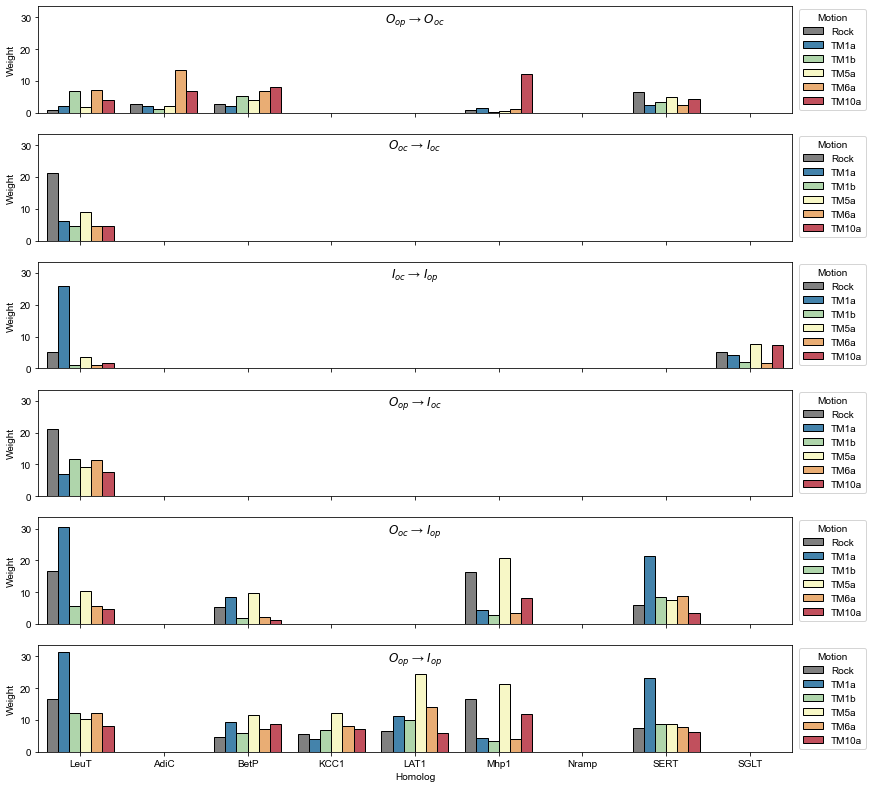

In [51]:
fig, ax = plt.subplots(6,1,figsize=(9*6*0.25,2.2857*6),sharex=True, sharey=True)

for nt,trans in enumerate(["$O_{op}$ → $O_{oc}$", 
                      "$O_{oc}$ → $I_{oc}$", 
                      "$I_{oc}$ → $I_{op}$", 
                      "$O_{op}$ → $I_{oc}$", 
                      "$O_{oc}$ → $I_{op}$", 
                      "$O_{op}$ → $I_{op}$"]):

    Xj = X.loc[X["transition"]==trans]
    
    #fig, ax = plt.subplots(figsize=(len(Xj)*0.25,2.2857))
    g = sns.barplot(data=Xj, x="protein_name", y="value", hue="PC", edgecolor="k", lw=1,
               hue_order = np.array([1, 0, 4, 2, 3, 5]), palette=pca_colors_bars, 
               order=("LeuT", "AdiC", "BetP", "KCC1", "LAT1", "Mhp1", "Nramp", "SERT", "SGLT"), ax=ax[nt])
    
    ax[nt].set_ylabel("Weight")
    ax[nt].set_xlabel(None)
    ax[nt].set_title(trans, y=0.8)
    
    ax[nt].set_ylim(0,33.5)

    leg = ax[nt].get_legend()
    leg.set_title("Motion")

    new_labels = ["Rock", "TM1a", "TM1b", "TM5a", "TM6a", "TM10a"]
    for t, l in zip(leg.texts, new_labels):
        t.set_text(l)

    sns.move_legend(ax[nt], (1.01, 0.03))

    #plt.legend(ax,s loc=(1.01, 0.1), labels=["Rock", "TM1a", "TM1b", "TM5a", "TM6a", "TM10a"])
    plt.xlabel("")
    plt.ylabel("Weight")

ax[-1].set_xlabel("Homolog")
#plt.savefig("PCA/all_by_all_pca_nonneg.pdf", bbox_inches="tight")

Let's make the plot for Figure 4:

In [ ]:
Fig4_info = np.array([["LeuT", "$O_{oc}$ → $I_{oc}$"],
             ["MntH", "$O_{op}$ → $I_{oc}$"],
             ["SERT", "$O_{oc}$ → $I_{op}$"],          
             ["BetP", "$O_{oc}$ → $I_{op}$"],
             ["Mhp1", "$O_{oc}$ → $I_{op}$"],
             ["KCC1", "$O_{op}$ → $I_{op}$"],
             ["LAT1", "$O_{op}$ → $I_{op}$"]])

Fig4_X = pd.concat([selector(X, {"protein_name": Fig4_info[k][0], 
             "transition": Fig4_info[k][1]}) for k in range(len(Fig4_info))])

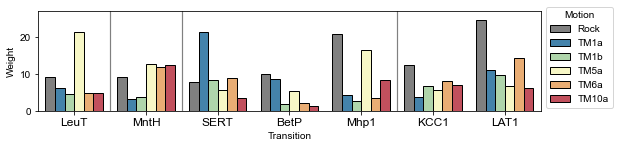

In [ ]:
fig, ax = plt.subplots(figsize=(len(LeuT_X)*0.25,2.2857*27/33.5))

g = sns.barplot(data=Fig4_X, x="protein_name", y="value", hue="PC", edgecolor="k", lw=1,
           hue_order = np.array([1, 0, 4, 2, 3, 5]),
           palette=pca_colors_bars)

plt.ylim(0,27)
plt.xlabel("Transition")
plt.ylabel("Weight")
#plt.title("LeuT conformational transitions")

leg = ax.get_legend()
leg.set_title("Motion")

new_labels = ["Rock", "TM1a", "TM1b", "TM5a", "TM6a", "TM10a"]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

sns.move_legend(ax, (1.01, 0.03))

plt.axvline(0.5, c='gray', lw=1.2)
plt.axvline(1.5, c='gray', lw=1.2)
plt.axvline(4.5, c='gray', lw=1.2)

plt.xticks(range(7), Fig4_info[:,0], size=12);

#plt.savefig("../../../Fig4.pdf", bbox_inches="tight")

In [ ]:
Fig5_info = np.array([["LeuT", "$I_{oc}$ → $I_{op}$"],
             ["MntH", "$I_{oc}$ → $I_{op}$"],
             ['SGLT', "$I_{oc}$ → $I_{op}$"],
             ["SERT", "$O_{oc}$ → $I_{op}$"],          
             ["BetP", "$O_{oc}$ → $I_{op}$"],
             ["Mhp1", "$O_{oc}$ → $I_{op}$"],
             ["KCC1", "$O_{op}$ → $I_{op}$"],
             ["LAT1", "$O_{op}$ → $I_{op}$"]])

Fig5_X = pd.concat([selector(X, {"protein_name": Fig5_info[k][0], 
             "transition": Fig5_info[k][1]}) for k in range(len(Fig5_info))])

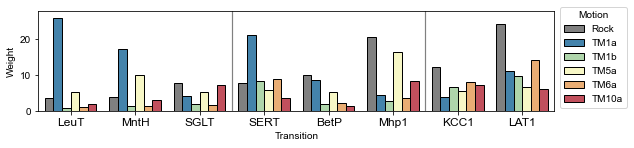

In [ ]:
fig, ax = plt.subplots(figsize=((len(LeuT_X)+1)*0.25,2.2857*27/33.5))

g = sns.barplot(data=Fig5_X, x="protein_name", y="value", hue="PC", edgecolor="k", lw=1,
           hue_order = np.array([1, 0, 4, 2, 3, 5]),
           palette=pca_colors_bars)

plt.ylim(0,28)
plt.xlabel("Transition")
plt.ylabel("Weight")
#plt.title("LeuT conformational transitions")

leg = ax.get_legend()
leg.set_title("Motion")

new_labels = ["Rock", "TM1a", "TM1b", "TM5a", "TM6a", "TM10a"]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

sns.move_legend(ax, (1.01, 0.03))

plt.axvline(2.5, c='gray', lw=1.2)
plt.axvline(5.5, c='gray', lw=1.2)
#plt.axvline(4.5, c='gray', lw=1.2)

plt.xticks(range(8), Fig5_info[:,0], size=12);

plt.savefig("../../../Fig5.pdf", bbox_inches="tight")

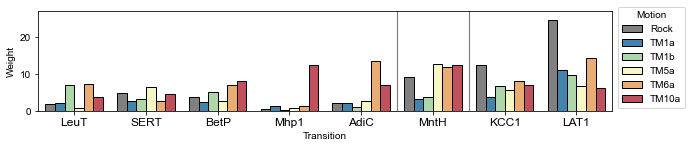

In [ ]:
Fig6_info = np.array([["LeuT", "$O_{op}$ → $O_{oc}$"],
             ["SERT", "$O_{op}$ → $O_{oc}$"],
             ["BetP", "$O_{op}$ → $O_{oc}$"],          
             ["Mhp1", "$O_{op}$ → $O_{oc}$"],
             ["AdiC", "$O_{op}$ → $O_{oc}$"],
             ["MntH", "$O_{op}$ → $I_{oc}$"],
             ["KCC1", "$O_{op}$ → $I_{op}$"],
             ["LAT1", "$O_{op}$ → $I_{op}$"]])

Fig6_X = pd.concat([selector(X, {"protein_name": Fig6_info[k][0], 
             "transition": Fig6_info[k][1]}) for k in range(len(Fig6_info))])

fig, ax = plt.subplots(figsize=(len(LeuT_X)*0.25 * 8 / 7,2.2857*27/33.5))

g = sns.barplot(data=Fig6_X, x="protein_name", y="value", hue="PC", edgecolor="k", lw=1,
           hue_order = np.array([1, 0, 4, 2, 3, 5]),
           palette=pca_colors_bars)

plt.ylim(0,27)
plt.xlabel("Transition")
plt.ylabel("Weight")
#plt.title("LeuT conformational transitions")

leg = ax.get_legend()
leg.set_title("Motion")

new_labels = ["Rock", "TM1a", "TM1b", "TM5a", "TM6a", "TM10a"]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

sns.move_legend(ax, (1.01, 0.03))

plt.axvline(4.5, c='gray', lw=1.2)
#plt.axvline(1.5, c='gray', lw=1.2)
plt.axvline(5.5, c='gray', lw=1.2)

plt.xticks(range(8), Fig6_info[:,0], size=12);

plt.savefig("../../../Fig6.pdf", bbox_inches="tight")